In [2]:
# Importing Libraries
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from IPython.display import Markdown as md
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from scipy.optimize import minimize

## Posted Wait Time Data EDA

In [3]:
# Opening + Cleaning Posted Wait Time Data
df = pd.read_csv('Posted_Wait_Times.csv')
df['dt'] = pd.to_datetime(df['datetime'])
df.drop(['date', 'datetime', 'SACTMIN'], axis = 1, inplace = True)
df['date'] = df['dt'].dt.date
df['time'] = df['dt'].dt.time
df['hour'] = df['dt'].dt.hour
df['month'] = df['dt'].dt.month
df.drop(['date'], axis = 1, inplace = True)
df.rename(columns = {'SPOSTMIN': 'wait'}, inplace = True)
df.dropna(inplace = True)
df = df[df['wait'] > 0]
df = df[['dt', 'month', 'hour', 'time', 'wait']]
print('Posted Wait Time Data')
df.head(5)

Posted Wait Time Data


,dt,month,hour,time,wait
0,2015-01-01 07:47:00,1,7,07:47:00,5.0
1,2015-01-01 07:54:00,1,7,07:54:00,5.0
2,2015-01-01 08:05:00,1,8,08:05:00,5.0
3,2015-01-01 08:12:00,1,8,08:12:00,5.0
4,2015-01-01 08:19:00,1,8,08:19:00,5.0


In [4]:
# Creating Data Frame for November 
november = df[(df['month'] == 11) & (df['hour'] >= 8) & (df['hour'] <= 20)].reset_index().drop('index', axis = 1)
print('November Posted Wait Time Data')
november.head(5)

November Posted Wait Time Data


,dt,month,hour,time,wait
0,2015-11-01 08:03:00,11,8,08:03:00,5.0
1,2015-11-01 08:10:00,11,8,08:10:00,5.0
2,2015-11-01 08:17:00,11,8,08:17:00,5.0
3,2015-11-01 08:24:00,11,8,08:24:00,5.0
4,2015-11-01 08:30:00,11,8,08:30:00,5.0


## Exploratory Data Analysis

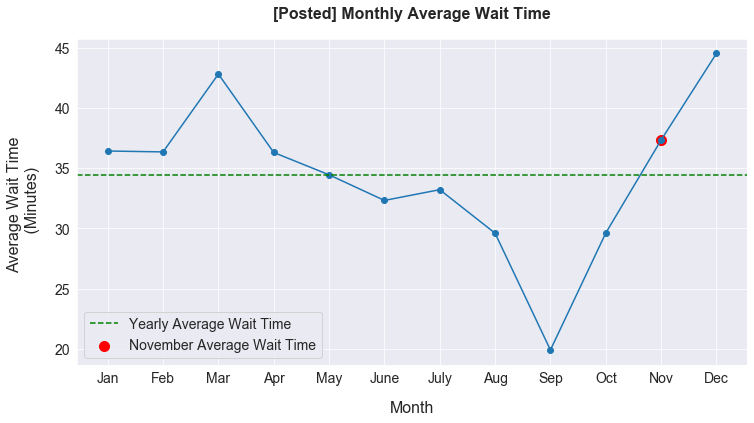

In [5]:
# Plotting Monthly Average Wait Time
sns.set_style('darkgrid')
fig0a, ax0a = plt.subplots(figsize = (12,6))


plt.plot(df.groupby('month').mean()['wait'].index, df.groupby('month').mean()['wait'].values, marker = 'o')
ax0a.axhline(y = np.mean(df['wait']), c = 'g',linestyle = 'dashed', label = 'Yearly Average Wait Time')
plt.scatter(11, np.mean(df[df['month'] == 11]['wait']), marker = 'o' , s = 100, c = 'r', label = 'November Average Wait Time')


plt.title('[Posted] Monthly Average Wait Time', fontsize = 16, pad = 20, fontweight = 'semibold')
plt.xlabel('Month', fontsize = 16, labelpad = 15)
plt.ylabel('Average Wait Time \n (Minutes)', fontsize = 16, labelpad = 15)
plt.xticks(df.groupby('month').mean()['wait'].index.to_list(), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June',
                                                               'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.legend(prop={'size': 14})
fig0a.savefig('fig0a.pdf')

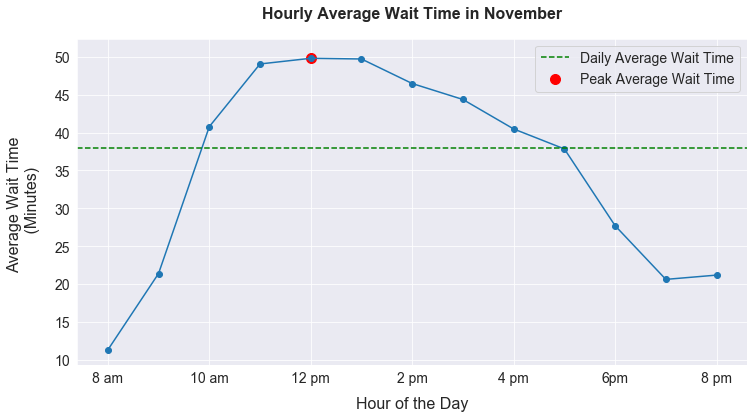

In [6]:
# Plotting Daily Average Wait Time vs. Hour
sns.set_style('darkgrid')
fig0b, ax0b = plt.subplots(figsize = (12, 6))

grouped_nov = november.groupby('hour').mean()[['wait']]

plt.plot(grouped_nov.index.to_list(), grouped_nov['wait'], marker = 'o')
ax0b.axhline(y = np.mean(november['wait']), c = 'g',linestyle = 'dashed', label = 'Daily Average Wait Time')
plt.scatter(12, november.groupby('hour', as_index = True).mean()[['wait']].max(), 
            marker = 'o' , s = 100, c = 'r', label = 'Peak Average Wait Time')


plt.title('Hourly Average Wait Time in November', fontsize = 16, pad = 20, fontweight = 'semibold')
plt.xlabel('Hour of the Day', fontsize = 16, labelpad = 10)
plt.ylabel('Average Wait Time \n (Minutes)', fontsize = 16, labelpad = 15)
plt.xticks([8,10,12,14,16,18,20], ['8 am', '10 am', '12 pm', '2 pm', '4 pm', '6pm', '8 pm'], fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(prop={'size': 14})
fig0b.savefig('fig0b.pdf')

In [7]:
## Loading in November Arrival Data ## 
rates = pd.read_csv('november_arrival_data.csv')
rates['day'] = pd.to_datetime(rates['date'])
rates = rates.drop('date', axis = 1)
rates = rates[['day', 'open', 'peak', 'afternoon']]
rates = rates.rename( columns = {'day' : 'Date', 
                                 'open' : '8', 
                                 'peak' : '11',
                                 'afternoon' : '4', })
rates = rates.dropna()
rates.head(5)

,Date,8,11,4
0,2019-11-01,1517,3330,3090.0
1,2019-11-02,1540,2820,3870.0
2,2019-11-03,1517,3210,3090.0
3,2019-11-04,1657,3000,2820.0
4,2019-11-05,1517,3180,2640.0


In [8]:
# Removing Outliers 
rates2 = rates.drop('Date', axis = 1)
q1 = rates2.quantile(0.25)
q3 = rates2.quantile(0.75)
IQR = q3 - q1
LB = q1 - 1.25*IQR
UB = q3 + 1.25*IQR

rates_in_8 = rates2[ (rates2['8'].between(LB[0], UB[0])) ]['8'].values
rates_out_8 = rates2[ ~(rates2['8'].between(LB[0], UB[0])) ]['8'].values

rates_in_11 = rates2[ (rates2['11'].between(LB[1], UB[1])) ]['11'].values
rates_out_11 = rates2[ ~(rates2['11'].between(LB[1], UB[1])) ]['11'].values

rates_in_4 = rates2[ (rates2['4'].between(LB[2], UB[2])) ]['4'].values
rates_out_4 = rates2[ ~(rates2['4'].between(LB[2], UB[2])) ]['4'].values


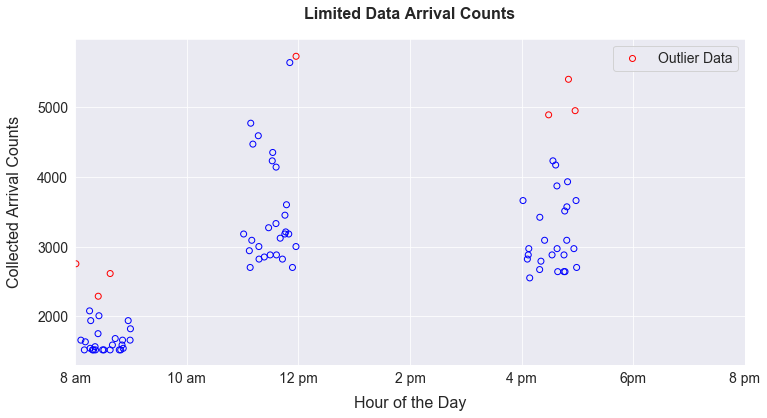

In [9]:
# Scatterplot of Arrivals 
sns.set_style('darkgrid')
fig0c, ax0c = plt.subplots(figsize = (12, 6))

plt.scatter(np.random.uniform(0,1, len(rates_in_8)), rates_in_8, facecolors='none', edgecolors ='b')
plt.scatter(np.random.uniform(3,4, len(rates_in_11)), rates_in_11, facecolors='none', edgecolors ='b')
plt.scatter(np.random.uniform(8,9, len(rates_in_4)), rates_in_4, facecolors='none', edgecolors ='b')

plt.scatter(np.random.uniform(0,1, len(rates_out_8)), rates_out_8, facecolors='none', edgecolors ='r', label = 'Outlier Data')
plt.scatter(np.random.uniform(3,4, len(rates_out_11)), rates_out_11, facecolors='none', edgecolors ='r')
plt.scatter(np.random.uniform(8,9, len(rates_out_4)), rates_out_4, facecolors='none', edgecolors ='r')

plt.title('Limited Data Arrival Counts', fontsize = 16, pad = 20, fontweight = 'semibold')
plt.xlabel('Hour of the Day', fontsize = 16, labelpad = 10)
plt.ylabel('Collected Arrival Counts', fontsize = 16, labelpad = 15)
plt.xticks([0,2,4,6,8,10,12], ['8 am', '10 am', '12 pm', '2 pm', '4 pm', '6pm', '8 pm'], fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlim(0, 12)
plt.legend(prop={'size': 14})
fig0c.savefig('fig0c.pdf')

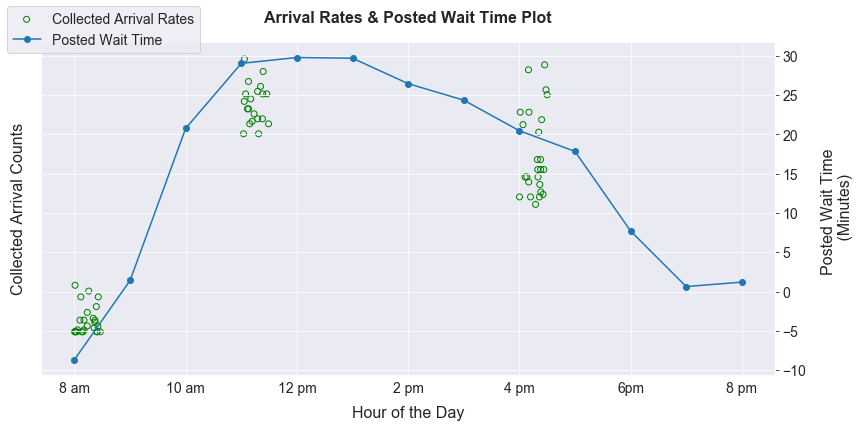

In [10]:
# Adding Horizontal Noise to Plot

random1, random2, random3 = np.random.uniform(8,8.5, len(rates_in_8)),np.random.uniform(11,11.5, len(rates_in_11)),np.random.uniform(16,16.5, len(rates_in_4))


fig, ax1 = plt.subplots(figsize = (12,6))

ax1.set_xlabel('Hour of the Day', fontsize = 16, labelpad = 10)
ax1.set_ylabel('Collected Arrival Counts', fontsize = 16, labelpad = 15)
plt.yticks([],fontsize = 14)

ax1.scatter(random1, rates_in_8-1000, facecolors='none', edgecolors ='g', label = 'Collected Arrival Rates')
ax1.scatter(random2, rates_in_11+200, facecolors='none', edgecolors ='g')
ax1.scatter(random3, rates_in_4-500, facecolors='none', edgecolors ='g')
plt.ylim(0,4000)
plt.xticks([8,10,12,14,16,18,20], ['8 am', '10 am', '12 pm', '2 pm', '4 pm', '6pm', '8 pm'], fontsize = 14)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Posted Wait Time \n (Minutes)', fontsize = 16, labelpad = 15)
ax2.plot(grouped_nov.index.to_list(), grouped_nov['wait'] - 20, marker = 'o', label = 'Posted Wait Time')
plt.yticks(fontsize = 14)
plt.xticks([8,10,12,14,16,18,20], ['8 am', '10 am', '12 pm', '2 pm', '4 pm', '6pm', '8 pm'], fontsize = 14)
plt.title('Arrival Rates & Posted Wait Time Plot', fontsize = 16, pad = 20, fontweight = 'semibold')
fig.tight_layout()  
fig.legend(prop={'size': 14}, loc = 'upper left')
fig.savefig('fig0d.pdf')